## Benchmark different map predictions with simple robot observation in-the-loop
* can be given a trajectory, or (later on) with exploration using predicted map in loop

In [40]:
# Third party imports
import torch
import os 
from torchvision.transforms import ToTensor, Resize, Compose
import PIL
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
import matplotlib.patches as patches
from torchmetrics.classification import JaccardIndex
import numpy as np
from tqdm import tqdm
from scipy.ndimage.morphology import distance_transform_cdt

# Custom imports
import sys
sys.path.append('../../')
# from gen_building_utils import * 
from options.deploy_options import *
from models.predictors import get_predictor_from_options
from eval_deploy import deploy_utils as dutils
from eval_deploy import viz_utils as vutils
from eval_deploy import glocal_utils as glocal
from data_factory import gen_building_utils 
from data_factory import simple_mask_utils as smu

# refresh jupyter modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Problem Inputs 
ensemble_folder_name = 'sc_map_pred_ensemble1' # Path to ensemble folder, in weights folder
map_configs = {
    'min_start_end_dist': 50,
    'collect_interval_m': 5,
    'laser_range': 50,
    'num_laser': 500,
    'num_rand_traj_per_map':1,
    'percent_test': 0.2,
    "local_map_size": 30, # TODO: add multiplier 
}


## Intialize deploy variables given main variables


In [4]:

# Initialize options
cmd_line_args_dict = ['--name', 'deploy']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

os.environ['L2M_root_path'] = '/home/cherie/research/hmap/map_prediction_toolbox/' # change for different computer
options = DeployOptions().parse_args(cmd_line_args_dict)

# Initialize model ensembles # TODO: make into function
ensemble_dir = os.path.join(options.root_path, 'weights', ensemble_folder_name)
assert os.path.exists(ensemble_dir), "Ensemble dir does not exist"
ensemble_exp = os.listdir(ensemble_dir)
ensemble_exp.sort()
models_dict = {}
ensemble_size = len(ensemble_exp)
for n in range(ensemble_size):
    models_dict[n] = {'predictor_model': get_predictor_from_options(options)}
    models_dict[n] = {k:v.to(device) for k,v in models_dict[n].items()}
    models_dict[n]['predictor_model'] = torch.nn.DataParallel(models_dict[n]['predictor_model'])
    checkpoint_dir = ensemble_dir + "/" + ensemble_exp[n]
    latest_checkpoint = dutils.get_latest_model(save_dir=checkpoint_dir)
    models_dict[n] = dutils.load_model(models=models_dict[n], checkpoint_file=latest_checkpoint)
    models_dict[n]["predictor_model"].eval()
    print("Model {}: loading checkpoint {}".format(n, latest_checkpoint))





Model 0: loading checkpoint /home/cherie/research/hmap/map_prediction_toolbox/weights/sc_map_pred_ensemble1/sc_map_pred_v1_0/checkpoints/2023_08_01-09_13_05.pt
Model 1: loading checkpoint /home/cherie/research/hmap/map_prediction_toolbox/weights/sc_map_pred_ensemble1/sc_map_pred_v1_1/checkpoints/2023_08_01-09_37_10.pt


## Make random map and trajectory, then get local observations
* should be similar to gen_building_mask
* Observation is local map mask 

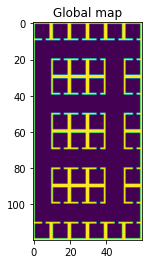

[0. 1.]
start: (21, 6), end: (91, 18)
Map shape:  (600, 300)
Mask list shape:  (600, 300)


In [5]:
# Generate a global ground-truth occupancy grid 
building_occ_map = gen_building_utils.make_building_occ_map()
building_occ_map = smu.convert_012_labels_to_maskutils_labels(building_occ_map)

# Randomize if transpose 

if np.random.rand() > 0.5:
    building_occ_map = building_occ_map.T
# 

plt.imshow(building_occ_map)
plt.title("Global map")
plt.show()

# Get list of local masks given a random trajectory
# TODO: set it to take in a trajectory instead 
map, mask_list, local_mask_list, local_gt_list, pose_list = smu.make_masklist_with_rand_traj_in_map(building_occ_map, map_configs, show_viz=False)

# Make everything 5 times bigge
multiplier = 5
map = dutils.make_map_larger(map, multiplier)
mask_list = [dutils.make_map_larger(map, multiplier) for map in mask_list]
local_mask_list = [dutils.make_map_larger(map, multiplier) for map in local_mask_list]
local_gt_list = [dutils.make_map_larger(map, multiplier) for map in local_gt_list]
pose_list = pose_list * multiplier


print("Map shape: ", map.shape)
print("Mask list shape: ", mask_list[0].shape)


## Benchmark different prediction strategy with robot in loop 
* Given global ground truth map and trajectory above, we measure map error for different map prediction strategy

Strategies:
* No Map Prediction
* Local Prediction
* GLocal (Naive): Don't propagate map
* GLocal (Propagation)

Psuedocode:
```
* For each point in trajectory, we want to mock the prediction process
    * get current observed map
    * get predicted map (depends on strategy)
    * if needed, get indices of local predicted map in global map
    * update global map with local map
    * visualize global predicted map 
```

In [62]:
# Intialize transform 
local_transform = Compose([
            Resize((256, 256), interpolation= PIL.Image.NEAREST),
            ToTensor()
        ])

global_transform = Compose([
            ToTensor(),
        ]) # do not do any resizing

# Initialize metric function 
iou_metric = JaccardIndex(task="multiclass", num_classes=3, reduction="none")
from torchmetrics.image import StructuralSimilarityIndexMeasure
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0, reduction="none")


# Initialize metric lists for visualization 
iou_metric_obs_list = []
iou_metric_pred_list = []
iou_metric_pred_multi_list = []
iou_metric_pred_propagated_list = [] 
ssim_metric_obs_list = [] 
ssim_metric_pred_list = []
ssim_metric_pred_multi_list = []
ssim_metric_pred_propagated_list = []


# Initialize global maps for accumulation
init_value = 2 # init as free space

## Global map observed
global_map_obs = np.ones_like(map) * init_value 
global_obs_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(global_map_obs, global_transform)

## Global map predicted
global_map_pred = np.ones_like(map) * init_value 
global_pred_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(global_map_pred, global_transform)

## Global map predicted multi-patches 
global_map_pred_multi = np.ones_like(map) * init_value
global_pred_multi_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(global_map_pred_multi, global_transform)

## Global map predicted propagated
global_map_pred_propagated = np.ones_like(map) * init_value
global_pred_propagated_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(global_map_pred_propagated, global_transform)



## Collect metrics over trajectory
for i in tqdm(range(len(mask_list))):
    # Get local observed map
    local_observed_map = 1-local_mask_list[i]
    global_observed_map = 1-mask_list[i]

    # Get local predicted map    
    local_input_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(local_observed_map, local_transform)
    local_pred_mean_onehot, local_pred_ensemble_onehot = dutils.run_map_predictor(local_input_onehot_tensor, device, models_dict)


    # Get local GT map (for visualization)
    local_gt_map = 1-local_gt_list[i]
    local_gt_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(local_gt_map, local_transform)

    # Get global GT map (for visualization)
    global_map_gt = map 
    global_gt_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(global_map_gt, global_transform)

    # Accumulate global observed map
    local_map_center_in_global = pose_list[i]
    
    # # Update global observed map with newest global observed map 
    global_obs_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(global_observed_map, global_transform)
    # For metrics, get observed map where unobserved is free space 
    global_obs_freespace_tensor = dutils.change_onehot_unobserved_to_free(global_obs_onehot_tensor)
    # print("global_obs_onehot_tensor.shape: ", global_obs_onehot_tensor.shape)
    # print("global_observed_map.shape: ", global_observed_map.shape)
    # plt.imshow(global_observed_map)
    # plt.colorbar()
    # plt.show()
    # # Update global predicted map with local predicted map
    global_pred_onehot_tensor = dutils.update_global_map_with_local(global_pred_onehot_tensor, local_pred_mean_onehot, 
                                 robot_pose=local_map_center_in_global, local_map_size=map_configs['local_map_size']*multiplier)

    # # Update global predicted multi map with multi-patch inference
    stride_m = 10 # TODO: move up to config, should have seperate prediction config 
    global_pred_multi_onehot_tensor = glocal.calculate_global_pred_with_glocal_inference(global_obs_onehot_tensor,
                                                    global_pred_multi_onehot_tensor, 
                                                    map_configs, multiplier, 
                                                    stride_m, models_dict, 
                                                    device, show_viz=False)
    
    # # Get patch distance transform 
    known_threshold = 0.3 # TODO: move up to config, should have seperate prediction config 
    global_pred_propagate_onehot_tensor_rollouts = glocal.calculate_rollouts_global_map_prediction(models_dict, device, global_obs_onehot_tensor, map_configs, multiplier, stride_m, known_threshold, show_viz=False)
    print("global_pred_propagate_onehot_tensor_rollouts.shape: ", global_pred_propagate_onehot_tensor_rollouts.shape)
    global_pred_propagate_onehot_tensor_mean = torch.mean(global_pred_propagate_onehot_tensor_rollouts, dim=0).unsqueeze(0)

    # Get the variance 
    var_class = 1
    variance_global_pred_propagate_onehot_tensor = torch.var(global_pred_propagate_onehot_tensor_rollouts[:,var_class,:,:], dim=0)

    
    # # Calculate metrics
    ssim_metric_obs = dutils.get_ssim(ssim_metric, global_obs_freespace_tensor, global_gt_onehot_tensor)
    ssim_metric_obs_list.append(ssim_metric_obs)

    global_pred_freespace_tensor = dutils.change_onehot_unobserved_to_free(global_pred_onehot_tensor)
    ssim_metric_pred = dutils.get_ssim(ssim_metric, global_pred_freespace_tensor, global_gt_onehot_tensor)
    ssim_metric_pred_list.append(ssim_metric_pred)

    global_pred_multi_freespace_tensor = dutils.change_onehot_unobserved_to_free(global_pred_multi_onehot_tensor)
    ssim_metric_pred_multi = dutils.get_ssim(ssim_metric, global_pred_multi_freespace_tensor, global_gt_onehot_tensor)
    ssim_metric_pred_multi_list.append(ssim_metric_pred_multi)

    global_pred_propagated_freespace_tensor = dutils.change_onehot_unobserved_to_free(global_pred_propagate_onehot_tensor_mean)
    ssim_metric_pred_propagated = dutils.get_ssim(ssim_metric, global_pred_propagated_freespace_tensor, global_gt_onehot_tensor)
    ssim_metric_pred_propagated_list.append(ssim_metric_pred_propagated)


    iou_metric_obs = dutils.get_freq_iou(iou_metric, global_obs_freespace_tensor, global_gt_onehot_tensor)
    iou_metric_obs_list.append(iou_metric_obs)

    iou_metric_pred = dutils.get_freq_iou(iou_metric, global_pred_freespace_tensor, global_gt_onehot_tensor)
    # print("iou_metric_pred: ", iou_metric_pred)
    iou_metric_pred_list.append(iou_metric_pred)

    iou_metric_pred_multi = dutils.get_freq_iou(iou_metric, global_pred_multi_freespace_tensor, global_gt_onehot_tensor)
    # print("iou_metric_pred_multi: ", iou_metric_pred_multi)
    iou_metric_pred_multi_list.append(iou_metric_pred_multi)

    iou_metric_pred_propagated = dutils.get_freq_iou(iou_metric, global_pred_propagated_freespace_tensor, global_gt_onehot_tensor)
    # print("iou_metric_pred_propagated: ", iou_metric_pred_propagated)
    iou_metric_pred_propagated_list.append(iou_metric_pred_propagated)

    # Converting one hot tensors to colorized and then visualize 
    plt_row = 3
    plt_col = 4

    plot_num_global_gt = 1
    plot_num_local_input = 2
    plot_num_local_pred = 3
    plot_num_metrics = 4
    plot_num_global_obs = 5
    plot_num_global_pred = 6
    plot_num_global_pred_multi = 7
    plot_num_global_pred_propagated = 8
    plot_num_prop_pred_1 = 9 
    plot_num_prop_pred_2 = 10
    plot_num_prop_var = 11
    plot_num_prop_var_subsampled = 12

    plt.figure(figsize=(20,12), facecolor=(1,1,1))

    plt.subplot(plt_row,plt_col,plot_num_global_gt)
    colorized_gt_global = vutils.get_colorized_map(global_gt_onehot_tensor)
    plt.imshow(colorized_gt_global.permute(1,2,0).squeeze().detach().cpu().numpy()) 
    x_pose = pose_list[i,0]
    y_pose = pose_list[i,1]
    
    plt.scatter(y_pose, x_pose,c='r',marker='x', s=100) # robot pose 
    plt.plot(pose_list[:i+1,1], pose_list[:i+1,0],'r.') # robot past traj 
    local_map_size_multiplied = map_configs['local_map_size'] * multiplier
    rect = patches.Rectangle((y_pose - (local_map_size_multiplied/2), x_pose - (local_map_size_multiplied/2)), local_map_size_multiplied, local_map_size_multiplied, 
                             linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    # make a rectangle
    plt.title("Global map gt")


    plt.subplot(plt_row,plt_col,plot_num_local_input)
    # plt.imshow(local_observed_map)
    colorized_input = vutils.get_colorized_map(local_input_onehot_tensor)
    colorized_input_permuted = colorized_input.permute(1,2,0).squeeze().detach().cpu().numpy()
    plt.imshow(colorized_input_permuted)
    plt.scatter(colorized_input_permuted.shape[1]//2, colorized_input_permuted.shape[0]//2,c='r', s=10) # robot pose
    plt.title("Local map input")

    plt.subplot(plt_row,plt_col,plot_num_local_pred)
    colorized_mean = vutils.get_colorized_map(local_pred_mean_onehot)
    plt.imshow(colorized_mean.permute(1,2,0).squeeze().detach().cpu().numpy())
    plt.scatter(colorized_input_permuted.shape[1]//2, colorized_input_permuted.shape[0]//2,c='r', s=10) # robot pose
    plt.title("Local map predicted")

    # plt.subplot(plt_row,plt_col,3)
    # colorized_gt = vutils.get_colorized_map(local_gt_onehot_tensor)
    # plt.imshow(colorized_gt.permute(1,2,0).squeeze().detach().cpu().numpy())
    # plt.scatter(colorized_input_permuted.shape[1]//2, colorized_input_permuted.shape[0]//2,c='r', s=10) # robot pose
    # plt.title("Local map GT")

    plt.subplot(plt_row,plt_col,plot_num_global_obs)
    colorized_obs_global = vutils.get_colorized_map(global_obs_freespace_tensor)
    plt.imshow(colorized_obs_global.permute(1,2,0).squeeze().detach().cpu().numpy())
    plt.title("No Map Prediction")

    plt.subplot(plt_row,plt_col,plot_num_global_pred)
    colorized_pred_global = vutils.get_colorized_map(global_pred_freespace_tensor)
    plt.imshow(colorized_pred_global.permute(1,2,0).squeeze().detach().cpu().numpy())
    plt.title("Only Local Prediction")

    plt.subplot(plt_row,plt_col,plot_num_global_pred_multi)
    colorized_pred_global_mult = vutils.get_colorized_map(global_pred_multi_freespace_tensor)
    plt.imshow(colorized_pred_global_mult.permute(1,2,0).squeeze().detach().cpu().numpy())
    plt.title("GLocal: No Propagation")

    plt.subplot(plt_row,plt_col,plot_num_global_pred_propagated)
    colorized_pred_global_propagated = vutils.get_colorized_map(global_pred_propagated_freespace_tensor)
    plt.imshow(colorized_pred_global_propagated.permute(1,2,0).squeeze().detach().cpu().numpy())
    plt.title("GLocal: With Propagation")





    ## Metrics 
    plt.subplot(plt_row,plt_col,plot_num_metrics)
    # plt.plot(iou_metric_obs_list, label="No Pred.")
    # plt.plot(iou_metric_pred_list, label="Local Pred.")
    # plt.plot(iou_metric_pred_multi_list, label="GLocal: No Prop.")
    # plt.plot(iou_metric_pred_propagated_list, label="GLocal: With Prop.")
    # plt.title("Freq-weighted IOU metric")

    plt.plot(ssim_metric_obs_list, label="No Pred. (SSIM)")
    plt.plot(ssim_metric_pred_list, label="Local Pred. (SSIM)")
    plt.plot(ssim_metric_pred_multi_list, label="GLocal: No Prop. (SSIM)")
    plt.plot(ssim_metric_pred_propagated_list, label="GLocal: With Prop. (SSIM)") 
    plt.title("SSIM metric")
    plt.xlim(0, len(mask_list))
    plt.ylim(0, 1)
    plt.legend()
    
    # # Plot variance of multiple propagataion 
    plt.subplot(plt_row,plt_col,plot_num_prop_pred_1)
    colorized_pred_global_propagated = vutils.get_colorized_map(global_pred_propagate_onehot_tensor_rollouts[0].unsqueeze(0))
    plt.imshow(colorized_pred_global_propagated.permute(1,2,0).squeeze().detach().cpu().numpy())
    plt.title("GLocal: Prop. 1")

    plt.subplot(plt_row,plt_col,plot_num_prop_pred_2)
    colorized_pred_global_propagated = vutils.get_colorized_map(global_pred_propagate_onehot_tensor_rollouts[1].unsqueeze(0))
    plt.imshow(colorized_pred_global_propagated.permute(1,2,0).squeeze().detach().cpu().numpy())
    plt.title("GLocal: Prop. 2")
    

    plt.subplot(plt_row, plt_col, plot_num_prop_var)
    plt.imshow(variance_global_pred_propagate_onehot_tensor,vmin=0, vmax=1)
    plt.title("variance of class {}".format(var_class))
    plt.colorbar()

    subsampling_freq = 50

    subsampled = np.zeros((int(variance_global_pred_propagate_onehot_tensor.shape[0]/subsampling_freq), int(variance_global_pred_propagate_onehot_tensor.shape[1]/subsampling_freq)))
    for sub_i in range(int(variance_global_pred_propagate_onehot_tensor.shape[0]/subsampling_freq)):
        for sub_j in range(int(variance_global_pred_propagate_onehot_tensor.shape[1]/subsampling_freq)):
            query_patch = variance_global_pred_propagate_onehot_tensor[sub_i*subsampling_freq:(sub_i+1)*subsampling_freq,sub_j*subsampling_freq:(sub_j+1)*subsampling_freq]
            subsampled[sub_i,sub_j] = torch.sum(query_patch)
    plt.subplot(plt_row, plt_col, plot_num_prop_var_subsampled)
    plt.imshow(subsampled, vmin=0, vmax = 500)
    plt.title("subsampled")
    plt.colorbar()
    print("i: ", i)
    plt.savefig("outputs/plot_{:04d}.png".format(i))
    plt.close()


/home/cherie/mambaforge/envs/map_pred/lib/python3.6/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
  0%|          | 0/20 [00:00<?, ?it/s]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  0


  5%|▌         | 1/20 [00:01<00:34,  1.79s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  1


 10%|█         | 2/20 [00:03<00:33,  1.89s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  2


 15%|█▌        | 3/20 [00:06<00:36,  2.12s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  3


 20%|██        | 4/20 [00:09<00:36,  2.29s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  4


 25%|██▌       | 5/20 [00:11<00:35,  2.38s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  5


 30%|███       | 6/20 [00:14<00:34,  2.49s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  6


 35%|███▌      | 7/20 [00:17<00:32,  2.52s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  7


 40%|████      | 8/20 [00:19<00:30,  2.53s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  8


 45%|████▌     | 9/20 [00:22<00:28,  2.58s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  9


 50%|█████     | 10/20 [00:25<00:26,  2.62s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  10


 55%|█████▌    | 11/20 [00:27<00:23,  2.66s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  11


 60%|██████    | 12/20 [00:30<00:21,  2.72s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  12


 65%|██████▌   | 13/20 [00:33<00:19,  2.72s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  13


 70%|███████   | 14/20 [00:36<00:16,  2.71s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  14


 75%|███████▌  | 15/20 [00:38<00:13,  2.71s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  15


 80%|████████  | 16/20 [00:41<00:10,  2.71s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  16


 85%|████████▌ | 17/20 [00:44<00:08,  2.75s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  17


 90%|█████████ | 18/20 [00:47<00:05,  2.73s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  18


 95%|█████████▌| 19/20 [00:49<00:02,  2.73s/it]

global_pred_onehot_tensor_list.shape: torch.Size([2, 3, 600, 300])
global_pred_propagate_onehot_tensor_rollouts.shape:  torch.Size([2, 3, 600, 300])
i:  19


100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


In [26]:
ssim_metric_obs = ssim_metric(torch.argmax(global_obs_onehot_tensor, dim=1).float().unsqueeze(1), target_tensor_argmax.float().unsqueeze(1))
# torch.argmax(global_gt_onehot_tensor, dim=1).shape
# target_tensor_argmax.shape
ssim_metric_obs

tensor(0.0139)

##  Get and visualize local patches
We want a figure where 
* on the left, we show global map with rectangles around the frames
* on the right, we show the patches and then maybe underneath the associated predictions

In [ ]:
# # Get global GT map (for visualization)
# i = 0
# global_map_gt = map 
# global_gt_onehot_tensor = dutils.convert_maputils_labelmaps_to_model_input_format(global_map_gt, global_transform)

# x_pose = pose_list[i,0]
# y_pose = pose_list[i,1]

# plt.scatter(y_pose, x_pose,c='r',marker='x', s=100) # robot pose 
# plt.plot(pose_list[:i+1,1], pose_list[:i+1,0],'r.') # robot past traj 
# local_map_size_multiplied = map_configs['local_map_size'] * multiplier
# # rect = patches.Rectangle((y_pose - (local_map_size_multiplied/2), x_pose - (local_map_size_multiplied/2)), local_map_size_multiplied, local_map_size_multiplied, 
# #                             linewidth=3, edgecolor='r', facecolor='none')
# # plt.gca().add_patch(rect)

# colorized_obs_global = vutils.get_colorized_map(global_obs_onehot_tensor)
# plt.imshow(colorized_obs_global.permute(1,2,0).squeeze().detach().cpu().numpy()) 
# plt.title("Global Obs map")


# # Given the global map shape and stride, get list of patch centers
# stride = [10 * multiplier, 10* multiplier] 
# patch_shape = [map_configs['local_map_size'] * multiplier, map_configs['local_map_size'] * multiplier]
# patch_centers = dutils.get_patch_centers(global_map_gt.shape, patch_shape, stride)
# print("Number of patches: ", len(patch_centers))
# # print("Patch centers: ", patch_centers)

# # Visualize the patch centers
# plt.scatter(patch_centers[:,1], patch_centers[:,0], c='b', marker='x', s=100) # patch centers
# for patch_center in patch_centers:
#     rect = patches.Rectangle((patch_center[1] - (local_map_size_multiplied/2), patch_center[0] - (local_map_size_multiplied/2)), local_map_size_multiplied, local_map_size_multiplied, 
#                             linewidth=3, edgecolor=vutils.generate_random_color(), facecolor='none')
#     plt.gca().add_patch(rect)

# plt.show()









## Get patches from global map given the patch centers


In [ ]:
# stride_m = 10 # meters
# global_pred_onehot_tensor = glocal.calculate_global_pred_with_glocal_inference(global_obs_onehot_tensor,
#                                                    global_pred_onehot_tensor, 
#                                                    map_configs, multiplier, 
#                                                    stride_m, models_dict, 
#                                                    device, show_viz=True)

## Prototype Iterative Map Prediction

In [52]:
dutils.change_onehot_unobserved_to_free(global_obs_onehot_tensor)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

In [ ]:
variance_global_pred_propagate_onehot_tensor.shape


In [ ]:
global_obs_onehot_tensor.shape